Step 1: Mount Google Drive and Install Required Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install --upgrade gspread pandas scikit-learn matplotlib seaborn
!pip install --upgrade gspread_dataframe


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 Step 2: Read .csv from Drive

In [ ]:
import pandas as pd

# Load the CSV file from Google Drive
df = pd.read_csv('/content/signal_metrics - signal_metrics.csv')

# Preview the data
df.head()


,Timestamp,Locality,Latitude,Longitude,Signal Strength (dBm),Signal Quality (%),Data Throughput (Mbps),Latency (ms),Network Type,BB60C Measurement (dBm),srsRAN Measurement (dBm),BladeRFxA9 Measurement (dBm)
0,2023-05-05 12:50:40,Anisabad,25.599109,85.137355,-84.274113,0.0,1.863890,129.122914,3G,0.000000,0.000000,0.000000
1,2023-05-05 12:53:47,Fraser Road,25.433286,85.070053,-97.653121,0.0,5.132296,54.883606,4G,-95.810791,-105.452359,-99.920892
2,2023-05-05 13:03:09,Phulwari Sharif,25.538556,85.159860,-94.564765,0.0,38.292038,30.342828,5G,-90.489100,-103.318303,-95.102467
3,2023-05-05 12:56:54,Boring Canal Road,25.498809,85.211371,-87.046134,0.0,1.176985,119.598286,LTE,-91.593861,-95.419482,-87.714070
4,2023-05-05 13:00:02,Danapur,25.735138,85.208400,-94.143159,0.0,68.596932,46.598387,5G,-90.642773,-101.895905,-96.570698


 Step 3: Clean and Preprocess Data

In [ ]:
# Drop rows where Latency or Throughput is NaN
df = df.dropna(subset=['Timestamp', 'Data Throughput (Mbps)', 'Latency (ms)'])

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract hour and minute
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute

# Keep necessary columns
df = df[['Timestamp', 'Hour', 'Minute', 'Data Throughput (Mbps)', 'Latency (ms)', 'Network Type']]
df = df.sort_values('Timestamp')


<ipython-input-7-d72095c51b5c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])
<ipython-input-7-d72095c51b5c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Timestamp'].dt.hour
<ipython-input-7-d72095c51b5c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

Step 4: Visualize Latency and Throughput by Hour

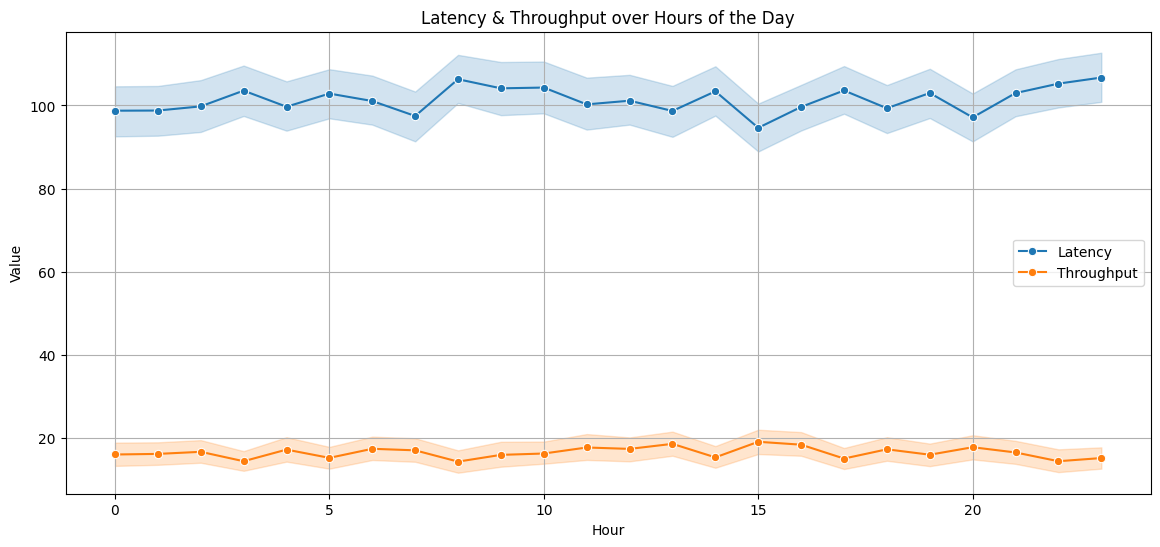

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='Hour', y='Latency (ms)', label='Latency', marker='o')
sns.lineplot(data=df, x='Hour', y='Data Throughput (Mbps)', label='Throughput', marker='o')
plt.title("Latency & Throughput over Hours of the Day")
plt.xlabel("Hour")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


 Step 5: ML Model to Predict Optimal Time Slot

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Features: Hour, Minute
X = df[['Hour', 'Minute']]
# Targets: Latency and Throughput
y_latency = df['Latency (ms)']
y_throughput = df['Data Throughput (Mbps)']

# Split data
X_train, X_test, y_latency_train, y_latency_test = train_test_split(X, y_latency, test_size=0.2, random_state=42)
X_train2, X_test2, y_tp_train, y_tp_test = train_test_split(X, y_throughput, test_size=0.2, random_state=42)

# Fit models
latency_model = RandomForestRegressor(n_estimators=100, random_state=42)
latency_model.fit(X_train, y_latency_train)

throughput_model = RandomForestRegressor(n_estimators=100, random_state=42)
throughput_model.fit(X_train2, y_tp_train)


RandomForestRegressor(random_state=42)

Step 6: Predict Latency and Throughput for Every Hour


In [ ]:
# Step 1: Create raw time grid
raw_time_grid = pd.DataFrame([(h, m) for h in range(24) for m in [0, 15, 30, 45]], columns=['Hour', 'Minute'])

# Step 2: Predict latency (use a clean copy)
latency_input = raw_time_grid.copy()
predicted_latency = latency_model.predict(latency_input)

# Step 3: Predict throughput (use another clean copy — no extra columns)
throughput_input = raw_time_grid.copy()
predicted_throughput = throughput_model.predict(throughput_input)

# Step 4: Combine everything into a final DataFrame
time_grid = raw_time_grid.copy()
time_grid['Predicted_Latency'] = predicted_latency
time_grid['Predicted_Throughput'] = predicted_throughput

# Step 5: Score = Throughput / Latency (lower latency, higher throughput is better)
time_grid['Score'] = time_grid['Predicted_Throughput'] / time_grid['Predicted_Latency']

# Step 6: Sort and view optimal time slots
optimal_times = time_grid.sort_values(by='Score', ascending=False)
optimal_times.head(10)


,Hour,Minute,Predicted_Latency,Predicted_Throughput,Score
31,7,45,37.555717,53.860238,1.434142
83,20,45,45.835690,65.105245,1.420405
70,17,30,48.360620,57.913924,1.197543
34,8,30,57.269735,43.876586,0.766139
15,3,45,49.213769,36.082254,0.733174
18,4,30,47.357578,31.233250,0.659520
88,22,0,66.625962,30.638850,0.459864
0,0,0,63.394746,29.054488,0.458311
50,12,30,83.079977,37.711401,0.453917
36,9,0,88.005845,39.091680,0.444194


 Step 7: Visualize Top Optimal Time Slots

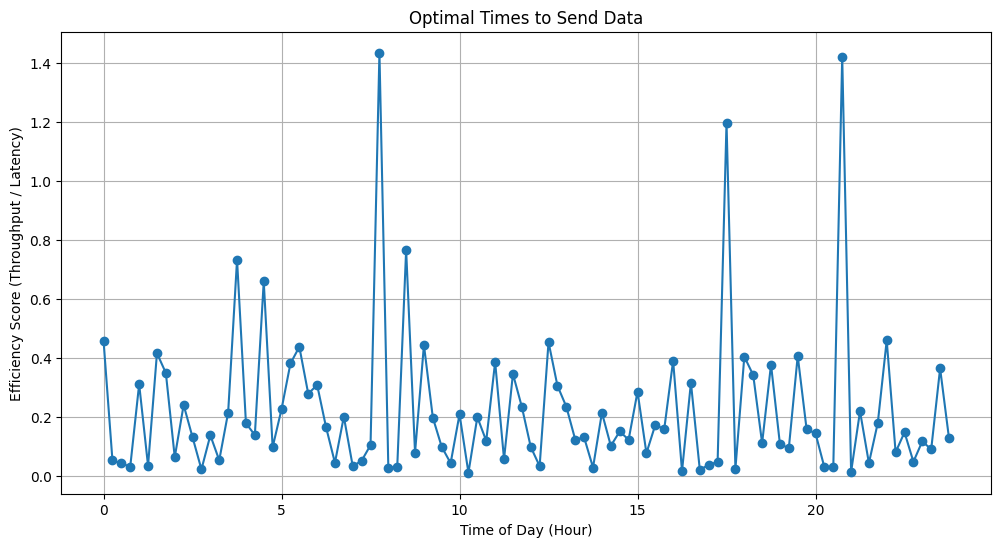

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(time_grid['Hour'] + time_grid['Minute'] / 60, time_grid['Score'], marker='o')
plt.xlabel('Time of Day (Hour)')
plt.ylabel('Efficiency Score (Throughput / Latency)')
plt.title('Optimal Times to Send Data')
plt.grid(True)
plt.show()


We’ll:

✅ Include more features like Network Type

🚀 Use Random Forest (a more powerful model)

💾 Export the top time slots to **CSV**

 Step 1: Encode Categorical Variables

In [ ]:
# Convert 'Timestamp' to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract hour and minute
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute

# Encode Network Type as dummy variables (one-hot encoding)
df_encoded = pd.get_dummies(df, columns=['Network Type'], drop_first=True)

# Drop rows with NaNs (just in case)
df_encoded.dropna(subset=['Latency (ms)', 'Data Throughput (Mbps)'], inplace=True)


Step 2: Train a Random Forest Regressor for Latency & Throughput

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Features: Hour, Minute + one-hot encoded network types
features = ['Hour', 'Minute'] + [col for col in df_encoded.columns if col.startswith("Network Type_")]

# Target 1: Latency
X_latency = df_encoded[features]
y_latency = df_encoded['Latency (ms)']

# Target 2: Throughput
y_throughput = df_encoded['Data Throughput (Mbps)']

# Split and train
latency_model = RandomForestRegressor(n_estimators=100, random_state=42)
latency_model.fit(X_latency, y_latency)

throughput_model = RandomForestRegressor(n_estimators=100, random_state=42)
throughput_model.fit(X_latency, y_throughput)


RandomForestRegressor(random_state=42)

Step 3: Predict Optimal Times Across Network Types

In [ ]:
# Create combinations for each 15-min slot and network type
network_types = df['Network Type'].unique()

time_slots = []
for net in network_types:
    for h in range(24):
        for m in [0, 15, 30, 45]:
            time_slots.append({'Hour': h, 'Minute': m, 'Network Type': net})

time_grid = pd.DataFrame(time_slots)

# One-hot encode network type to match training features
time_encoded = pd.get_dummies(time_grid, columns=['Network Type'])

# Add missing columns (if any) to match training data
for col in X_latency.columns:
    if col not in time_encoded.columns:
        time_encoded[col] = 0

# Predict
time_grid['Predicted_Latency'] = latency_model.predict(time_encoded[X_latency.columns])
time_grid['Predicted_Throughput'] = throughput_model.predict(time_encoded[X_latency.columns])
time_grid['Score'] = time_grid['Predicted_Throughput'] / time_grid['Predicted_Latency']

# Top 10 time slots
optimal_times = time_grid.sort_values(by='Score', ascending=False).head(10)
optimal_times


,Hour,Minute,Network Type,Predicted_Latency,Predicted_Throughput,Score
358,17,30,5G,16.498633,85.682110,5.193285
382,23,30,5G,20.478516,82.853674,4.045883
312,6,0,5G,20.258318,79.220342,3.910509
354,16,30,5G,17.798477,68.595880,3.854031
336,12,0,5G,19.722705,73.531376,3.728260
316,7,0,5G,23.274753,83.442009,3.585087
292,1,0,5G,21.579407,76.767733,3.557453
320,8,0,5G,20.645193,72.899355,3.531057
375,21,45,5G,19.760989,66.771781,3.378970
310,5,30,5G,24.039984,74.727372,3.108462


Step 4: Export to CSV

In [ ]:
optimal_times.to_csv('/content/optimal_time_slots.csv', index=False)


Heatmap Visualization (Time vs Network)

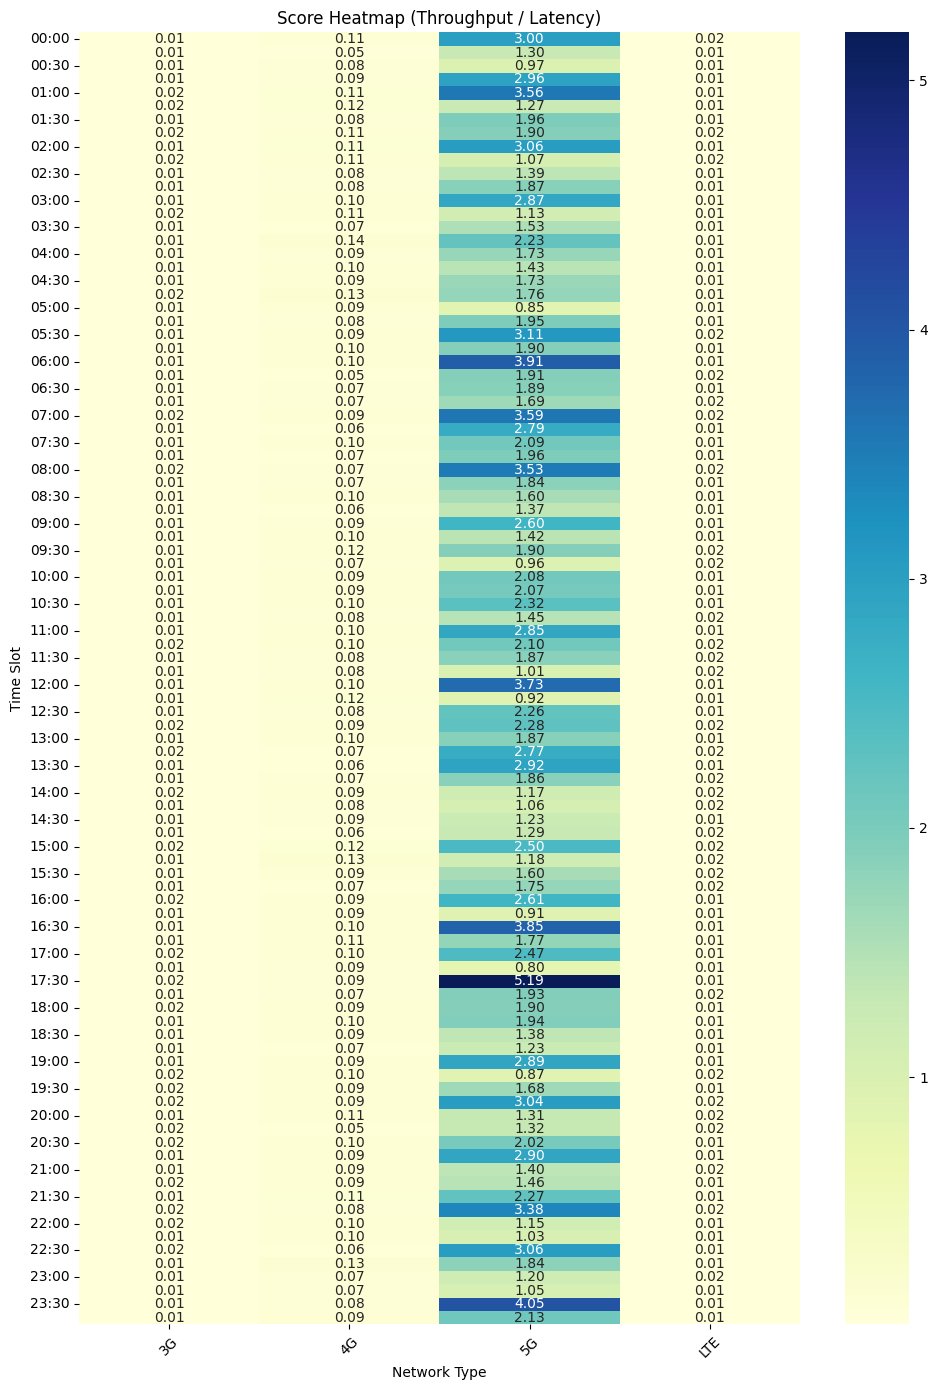

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert hour and minute to a readable time label
time_grid['Time'] = time_grid['Hour'].astype(str).str.zfill(2) + ':' + time_grid['Minute'].astype(str).str.zfill(2)

# Pivot table for heatmap
pivot = time_grid.pivot(index="Time", columns="Network Type", values="Score")

# Plot heatmap
plt.figure(figsize=(10, 14))
sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Score Heatmap (Throughput / Latency)")
plt.xlabel("Network Type")
plt.ylabel("Time Slot")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
